# Fit weighted histograms with SPD method

[Bohm and Zech (2014)](https://arxiv.org/abs/1309.1287) derived an approximate log-likelihood for weighted histograms with on average positive weights.

The authors show that their approximation yields less biased results than an approximate log-likelihood based on a normal distribution (equivalent to a least-squares fit). We confirm this here with a common HEP fit of a peak above a smooth background (here exponential). The tested weight distributions are normal, exponential, and uniform.

A notable bias is present even when the SPD method is used. The largest bias is found for exponentially distributed weights with deviations of 4-5% in the fitted parameters.

The remaining bias of the SPD method originates from the fact that the true weight variance in each bin is unknown and is replaced by the sample variance. This is inaccurate in bins with small number of samples and fails for empty bins, which must be skipped. The same is true for the alternative least-squares fit, however, and the biases are even larger there.

The study suggest that biases are larger if the weight distribution deviates more from the normal distribution.

In [1]:
#!pip install boost-histogram iminuit scipy matplotlib numpy numba progressbar2
import boost_histogram as bh
from iminuit import Minuit
from scipy.stats import norm, expon, uniform, poisson
from matplotlib import pyplot as plt
import numpy as np
import numba as nb
from progressbar import progressbar
import sys

In [26]:
@nb.njit
def cost_lsq(n, mu):
    r = 0.0
    for i in range(len(mu)):
        if n[i] == 0: continue
        r += (n[i] - mu[i]) ** 2 / n[i]
    return r


@nb.njit
def _cost_lsq_w(w, wvar, mu):
    r = 0.0
    for i in range(len(mu)):
        if wvar[i] == 0: continue
        r += (w[i] - mu[i]) ** 2 / wvar[i]
    return r


def cost_lsq_w(w, mu):
    return _cost_lsq_w(w.value, w.variance, mu)


@nb.njit
def cost_ml(n, mu):
    r = 0.0
    for i in range(len(mu)):
        r += mu[i] - n[i] * np.log(mu[i])
    return 2 * r


@nb.njit
def _cost_ml_w(w, wvar, mu):
    # Bohm and Zech, NIMA 748 (2014) 1-6
    r = 0.0
    for i in range(len(mu)):
        if wvar[i] > 0.0:
            s_inv = w[i] / wvar[i]
            mu_prime = mu[i] * s_inv
            n_prime = w[i] * s_inv        
            r += mu_prime - n_prime * np.log(mu_prime)
    return 2 * r


def cost_ml_w(w, mu):
    return _cost_ml_w(w.value, w.variance, mu)


weight_distributions = [None, np.ones, norm(1, 0.1).rvs, uniform(0, 2).rvs, expon().rvs]

nmc = 10000
mu_npts = 1000
signal_fraction = 0.2

truth = ((1.0 - signal_fraction), signal_fraction, 1.0, 2.0, 0.2)

pars = []
for wd in weight_distributions:
    np.random.seed(1)
    sub_pars = []
    sys.stdout.flush()
    for imc in progressbar(range(nmc)):
        # sample total number of points from poisson distribution
        npts = poisson(mu_npts).rvs()
        
        # generate background
        b = expon(scale=truth[2]).rvs(int(truth[0] * npts))
        
        # generate signal
        s = norm(truth[3], truth[4]).rvs(int(truth[1] * npts))
        x = np.append(b, s)

        # generate weights
        wi = wd(len(x)) if wd else None            

        if wi is None:
            h = bh.Histogram(bh.axis.Regular(20, 0, 3))
            h.fill(x)
            xe = h.axes[0].edges
            w = h.view()

        else:
            h = bh.Histogram(bh.axis.Regular(20, 0, 3), storage=bh.storage.Weight())
            h.fill(x, weight=wi)
            xe = h.axes[0].edges
            w = h.view()

        sub_sub_pars = []
        for fit_mode in range(2):
            if wi is None:
                if fit_mode == 0:
                    cost = cost_lsq
                else:
                    cost = cost_ml
            else:
                if fit_mode == 0:
                    cost = cost_lsq_w
                else:
                    cost = cost_ml_w

            def nll(par):
                bkg = expon(scale=par[2]).cdf(xe)
                sig = norm(par[3], par[4]).cdf(xe)
                mu_bkg = par[0] * npts * (bkg[1:] - bkg[:-1])
                mu_sig = par[1] * npts * (sig[1:] - sig[:-1])
                res = cost(w, mu_bkg + mu_sig)
                return res

            m = Minuit.from_array_func(
                nll,
                truth,
                limit=((0.0, None), (0.0, None), (0.0, None), None, (0.0, None)),
                pedantic=False,
            )

            m.migrad()
            assert m.migrad_ok()
            sub_sub_pars.append(m.np_values())
        sub_pars.append(sub_sub_pars)
    pars.append(sub_pars)
pars = np.array(pars)

100% (10000 of 10000) |##################| Elapsed Time: 0:40:49 Time:  0:40:49
100% (10000 of 10000) |##################| Elapsed Time: 0:41:05 Time:  0:41:05
100% (10000 of 10000) |##################| Elapsed Time: 0:40:54 Time:  0:40:54
100% (10000 of 10000) |##################| Elapsed Time: 0:46:46 Time:  0:46:46
100% (10000 of 10000) |##################| Elapsed Time: 2:12:31 Time:  2:12:31


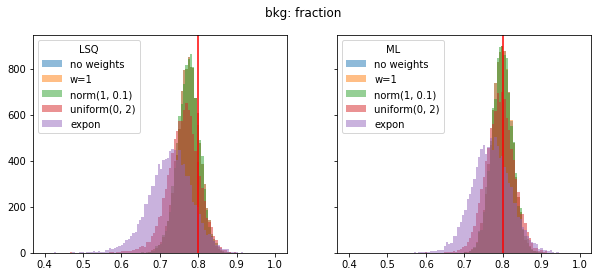

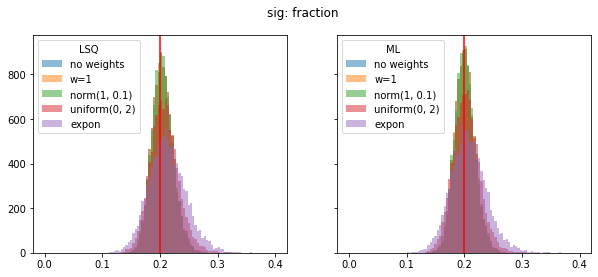

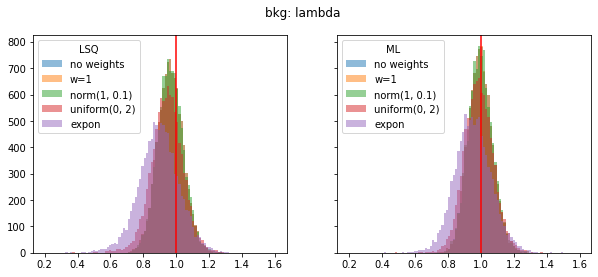

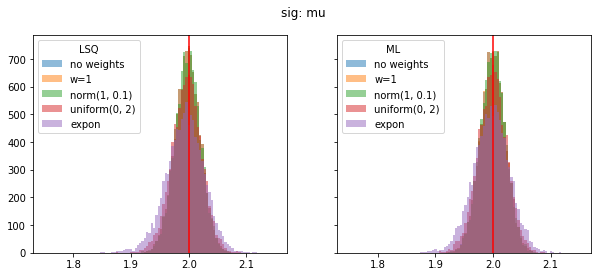

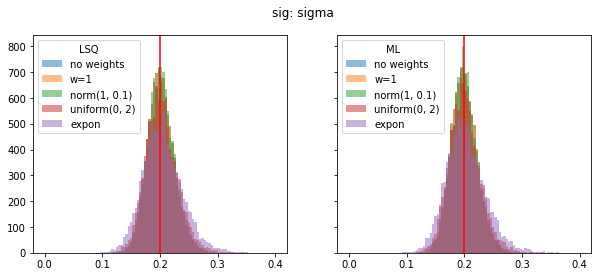

In [85]:
par_labels = ("bkg: fraction", "sig: fraction", "bkg: lambda", "sig: mu", "sig: sigma")
wd_labels = ("no weights","w=1", "norm(1, 0.1)", "uniform(0, 2)", "expon")
fit_labels = ("LSQ", "ML")
pars_range = ((0.4, 1.0), (0.0, 0.4), (0.2, 1.6), (1.75, 2.15), (0.0, 0.4))
for ipar, (par_label, t) in enumerate(zip(par_labels, truth)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    plt.suptitle(par_label)
    for iwd, wd_label in enumerate(wd_labels):
        for ifit, fit_label in enumerate(fit_labels):
            plt.sca(ax[ifit])
            p = pars[iwd, :, ifit, ipar]
            plt.hist(p, alpha=0.5, label=wd_label,
                     bins=100, range=pars_range[ipar])
    for label, axi in zip(fit_labels, ax):
        axi.axvline(t, color="r")
        axi.legend(loc="upper left", title=label)

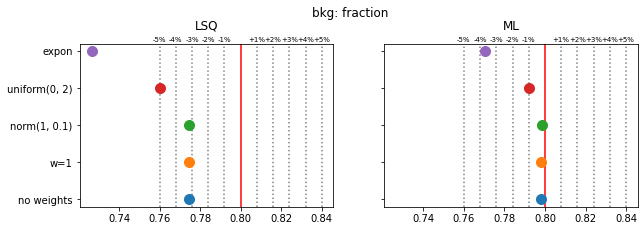

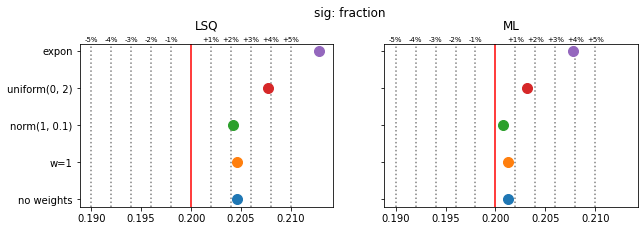

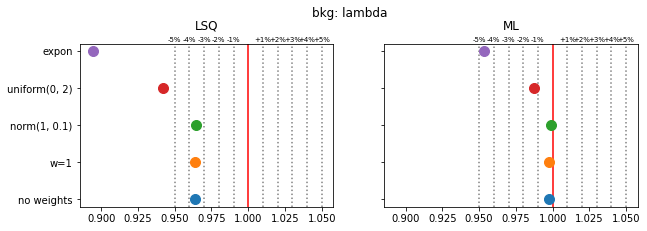

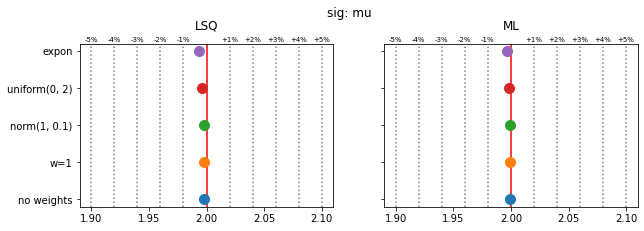

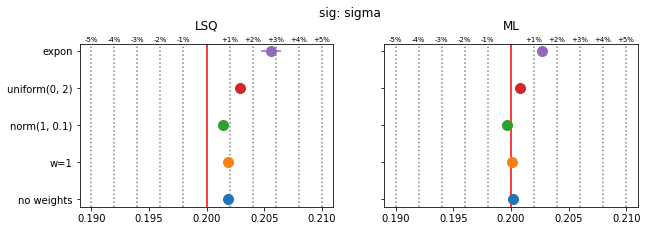

In [86]:
for ipar, (par_label, t) in enumerate(zip(par_labels, truth)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    plt.suptitle(f"{par_label}", y=1.05)
    for iwd, wd_label in enumerate(wd_labels):
        for ifit in range(2):
            plt.sca(ax[ifit])
            p = pars[iwd, :, ifit, ipar]
            mean = np.mean(p)
            sigma = np.std(p) / len(p) ** 0.5
            plt.errorbar(mean, iwd, 0, sigma, fmt="o", ms=10)
    for fit_label, axi in zip(fit_labels, ax):
        axi.set_title(fit_label, y=1.05)
        axi.axvline(t, color="r")
        for percent in (1, 2, 3, 4, 5):
            dt = t * 1e-2 * percent
            axi.axvline(t - dt, color="0.5", ls=":")
            axi.axvline(t + dt, color="0.5", ls=":")
            axi.text(t + dt, 1.01, f"+{percent}%", transform=axi.get_xaxis_transform(),
                     ha="center", fontsize="x-small")
            axi.text(t - dt, 1.01, f"-{percent}%", transform=axi.get_xaxis_transform(),
                     ha="center", fontsize="x-small")
    plt.sca(ax[0])
    plt.yticks(np.arange(len(wd_labels)), wd_labels)